In [ ]:
!pip install gdown
!pip install -U pysal
!pip install geopandas
!pip install torch_geometric pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric-temporal
!pip install --upgrade --force-reinstall git+https://github.com/FelipeSchreiber/COE770_Machine_Learning_on_Graphs.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... d

In [ ]:
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import *
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from dataset.covidBR_dataset import *
from google.colab import drive
from google.colab import runtime
import pickle
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')
device = "cpu"
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = "cuda"

Mounted at /content/drive


In [ ]:
device

'cuda'

In [ ]:
class MY_TGCN_(torch.nn.Module):
    def __init__(self, node_features,output_size=32):
        super(MY_TGCN_, self).__init__()
        self.recurrent = TGCN(node_features, output_size)
        self.linear = torch.nn.Linear(output_size, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state, c):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = self.linear(y)
        return y, h, None

class MY_A3TGCN_(torch.nn.Module):
    def __init__(self, node_features, output_size=32, periods = 1):
        super(MY_A3TGCN_, self).__init__()
        self.recurrent = A3TGCN(node_features, output_size, periods)
        self.linear = torch.nn.Linear(output_size, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h = self.recurrent(x.view(x.shape[0], 1, x.shape[1]), edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h, None, None

class MY_AGCRN_(torch.nn.Module):
    def __init__(self, node_features, output_size = 2, filter_size=2, num_nodes=5570,emb_dims=35):
        super(MY_AGCRN_, self).__init__()
        self.recurrent = AGCRN(number_of_nodes = num_nodes,
                              in_channels = node_features,
                              out_channels = output_size,
                              K = filter_size,
                              embedding_dimensions = emb_dims)
        self.linear = torch.nn.Linear(output_size, 1)
        self.num_nodes = num_nodes
        self.num_feats = node_features

    def forward(self, x, ignore, ignore_, h, e):
        x = x.view(1, self.num_nodes , self.num_feats)
        # print(h,e.shape)
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0, e

class MY_DCRNN_(torch.nn.Module):
    def __init__(self, node_features, output_size=32, filter_size=2):
        super(MY_DCRNN_, self).__init__()
        self.recurrent = DCRNN(in_channels=node_features, out_channels=output_size, K=filter_size)
        self.linear = torch.nn.Linear(output_size, 1)

    def forward(self, x, edge_index, edge_weight, h_, c):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h, None, None

class  MY_GConvGRU_(torch.nn.Module):
    def __init__(self, node_features, output_size=32, filter_size=2):
        super(MY_GConvGRU_, self).__init__()
        self.recurrent = GConvGRU(node_features, output_size, K = filter_size)
        self.linear = torch.nn.Linear(output_size, 1)

    def forward(self, x, edge_index, edge_weight, h_, c):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h, None, None

class MY_GCLSTM_(torch.nn.Module):
    def __init__(self, node_features,output_size, filter_size=2):
        super(MY_GCLSTM_, self).__init__()
        self.recurrent = GCLSTM(node_features, output_size, filter_size)
        self.linear = torch.nn.Linear(output_size, 1)
        # self.h = self.c = None

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0


def make_models(num_feats,output_size=32,filter_size=2,num_nodes=5570):
    # models = []
    # for layer in layers:
    #     models.append(RecurrentGCN(layer,output_size))
    models = [
              MY_TGCN_(node_features=num_feats, output_size = output_size),
              # MY_A3TGCN_(node_features = num_feats, output_size = output_size),
              MY_AGCRN_(node_features = num_feats, output_size = output_size, filter_size=filter_size,\
                        num_nodes=num_nodes,emb_dims=num_feats),
              MY_DCRNN_(node_features= num_feats),
              MY_GConvGRU_(node_features= num_feats, output_size=output_size, filter_size=filter_size)
              # MY_GCLSTM_(node_features= num_feats, output_size=output_size, filter_size=filter_size)
              ]
    model_names = ["TGCN","AGCRN","DCRNN","GConvGRU"]
    return models,model_names

In [ ]:
# class MY_DCRNN_(torch.nn.Module):
#     def __init__(self, node_features, output_size=32, filter_size=2):
#         super(MY_DCRNN_, self).__init__()
#         self.recurrent = DCRNN(in_channels=node_features, out_channels=output_size, K=filter_size)
#         self.linear = torch.nn.Linear(output_size, 1)

#     def forward(self, x, edge_index, edge_weight):
#         h = self.recurrent(x, edge_index, edge_weight)
#         h = F.relu(h)
#         h = self.linear(h)
#         return h

TGCN
MY_TGCN_(
  (recurrent): TGCN(
    (conv_z): GCNConv(4, 32)
    (linear_z): Linear(in_features=64, out_features=32, bias=True)
    (conv_r): GCNConv(4, 32)
    (linear_r): Linear(in_features=64, out_features=32, bias=True)
    (conv_h): GCNConv(4, 32)
    (linear_h): Linear(in_features=64, out_features=32, bias=True)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)
AGCRN
MY_AGCRN_(
  (recurrent): AGCRN(
    (_gate): AVWGCN()
    (_update): AVWGCN()
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)
DCRNN
MY_DCRNN_(
  (recurrent): DCRNN(
    (conv_x_z): DConv(36, 32)
    (conv_x_r): DConv(36, 32)
    (conv_x_h): DConv(36, 32)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)
GConvGRU
MY_GConvGRU_(
  (recurrent): GConvGRU(
    (conv_x_z): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_r): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_r): ChebConv(32, 32, K=2, nor

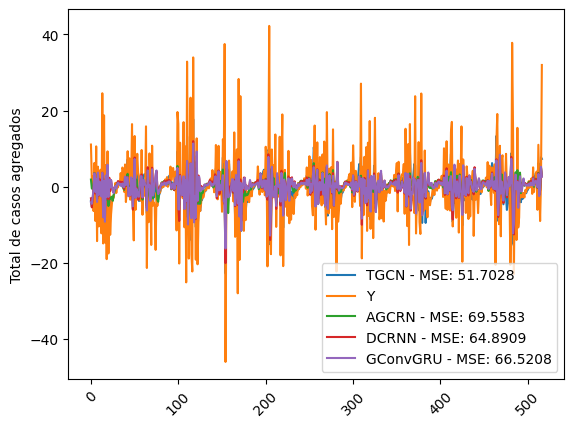

In [ ]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

# loader = CovidDatasetLoader(method="other")
# dataset = loader.get_dataset(lags=4)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

num_nodes = dataset[0].x.shape[0]
num_feats = dataset[0].x.shape[1]
filter_size=2
output_size=32

gdrive_path = "/content/drive/MyDrive/COE770_GNN/"
stats = {"MSE":[],"model":[]}
models,model_names = make_models(num_feats,output_size,num_nodes=num_nodes)

for model,model_name in zip(models,model_names):
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  h, c = None, None
  model.train()

  if model_name == "AGCRN":
    c = torch.empty(num_nodes, num_feats).to(device)
    torch.nn.init.xavier_uniform_(c)

  # for epoch in tqdm(range(50)):
  #     cost = 0
  #     for time, snapshot in enumerate(train_dataset):
  #         snapshot.to(device)
  #         y_hat,h,c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,h,c)
  #         cost = cost + torch.mean((y_hat-snapshot.y)**2)
  #     cost = cost / (time+1)
  #     cost.backward(retain_graph=True)
  #     optimizer.step()
  #     optimizer.zero_grad()
  #         # del snapshot
  #     if epoch % 10 == 0:
  #       filepath = f"./{model_name}"
  #       if (os.path.isfile(filepath)):
  #         os.remove(filepath)
  #       torch.save(model.state_dict(), filepath)
  #       torch.save(model.state_dict(), gdrive_path+model_name)
  # torch.save(model, f"./the_whole_model_{model_name}")
  # torch.save(model, gdrive_path+f"the_whole_model_{model_name}")
  # model.eval()
  # cost = 0
  # for time, snapshot in enumerate(test_dataset):
  #     snapshot.to(device)
  #     y_hat,h,c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,h,c)
  #     cost = cost + torch.mean((y_hat-snapshot.y)**2).item()
  #     del snapshot
  # cost = cost / (time+1)
  # stats["MSE"].append(cost)
  # stats["model"].append(model_name)
  print(model_name)
  model.load_state_dict(torch.load(gdrive_path+model_name))
  model.to(device)
  print(model)
  preds = []
  y = []
  cost = 0
  for time, snapshot in enumerate(dataset):
      snapshot.to(device)
      y_hat,h,c  = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,h,c )
      preds.append(y_hat.sum().cpu().detach().numpy())
      y.append(snapshot.y.sum().cpu().detach().numpy())
      cost+=(y[-1] - preds[-1])**2
      del snapshot
  plt.plot(preds,label=f"{model_name} - MSE: {cost/(time+1):.4f}")
  stats['MSE'].append(cost/(time+1))
  stats["model"].append(model_name)
  if model_name == "TGCN":
    plt.plot(y,label=f"Y")
  # print("MSE: {:.4f}".format(cost))
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# model_name="DCRNN"
# gdrive_path = "/content/drive/MyDrive/COE770_GNN/"
# torch.save(model.state_dict(), f"./{model_name}")
# torch.save(model.state_dict(), gdrive_path+model_name)

In [ ]:
"""
DCRNN: MSE: 69988044.3684
"""

In [ ]:
with open('covid_other_algos.pickle', 'wb') as handle:
    pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp "/content/covid_other_algos.pickle" "/content/drive/MyDrive"
test_0=None
with open("/content/drive/MyDrive/covid_other_algos.pickle", 'rb') as handle:
    test_0 = pickle.load(handle)
test_0.keys()

dict_keys(['MSE', 'model'])

In [ ]:
test_0

{'MSE': [], 'model': []}

In [ ]:
print("MSE: {:.4f}".format(cost))

In [ ]:
runtime.unassign()